# Trading strategies for NIFTY 50 Dataset

The data, which we have chosen is the Nifty50 data, downloaded from yfinance, from 2018 to 2022 , with 1day frequency.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
nifty_50_ticker = "^NSEI"

# Define the start and end dates
start_date = "2018-01-01"
end_date = "2024-01-01"

# Download Nifty 50 data
data = yf.download(nifty_50_ticker, start=start_date, end=end_date)

#columns = {'Open':'open','Low' :'low','Close': 'close','Volume': 'volume','High': 'high'}
#data = data.rename(columns = columns)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000
...,...,...,...,...,...,...
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500


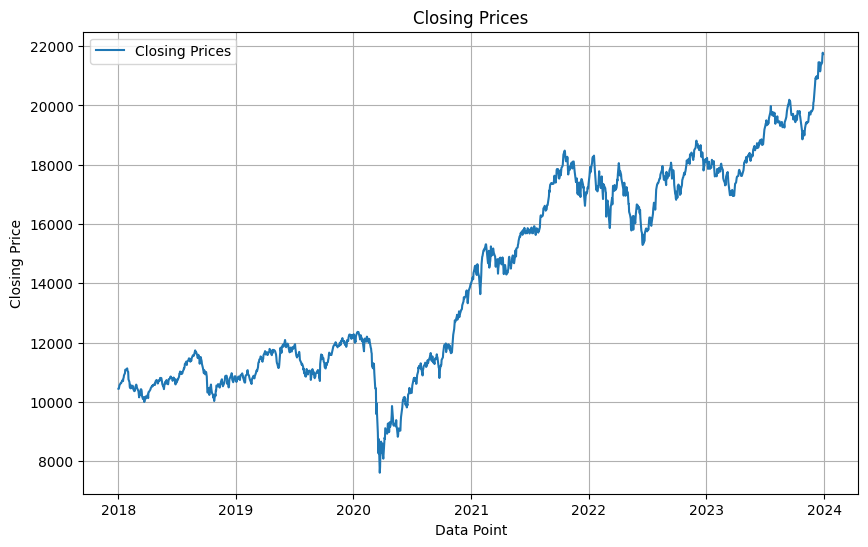

In [2]:
df = pd.DataFrame(data)

# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Prices', linestyle='-')
plt.title('Closing Prices')
plt.xlabel('Data Point')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

# The strategies we looked out

We conducted an extensive reseach on the nifty 50 market, how the stock prices behave, over a period of 4 years.
We also looked out for various indicators and strategies, which would outperform the market, to generate good returns.

Some of the strategies wew implemented include --

Stochastic Oscillator

Volume Weighted Average Price

ADX breakout strategy

Aroon oscillator

Super trend indicator

SMA crossovers


In [3]:
def get_stoch_slow(data, smooth = 5, window = 14):
  data['ll'] = data['Low'].rolling(window = window).min()
  data['hh'] = data['High'].rolling(window = window).max()
  ll = data['ll']
  hh = data['hh']
  close = data['Close']
  stoch = []
  for i in range(len(data)):
    if(pd.isna(hh[i])):
      stoch.append(0)
    else:
      val = 100*(close[i] - ll[i])/(hh[i]-ll[i])
      stoch.append(val)
  data['Stoch_osc'] = stoch
  data['k'] = data['Stoch_osc'].rolling(window = 3).mean()
  k = data['k']
  d = data['k'].rolling(window = smooth).mean()
  return data
data = get_stoch_slow(data)

def calculate_vwap(data):
    data['Typical Price'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['Volume * Typical Price'] = data['Volume'] * data['Typical Price']

    data['Cumulative Volume * Typical Price'] = data['Volume * Typical Price'].rolling(window = 14).sum()
    data['Cumulative Volume'] = data['Volume'].rolling(window = 14).sum()

    data['VWAP'] = data['Cumulative Volume * Typical Price'] / data['Cumulative Volume']

    return data
data = calculate_vwap(data)

In [4]:
def get_adx(data, window_size = 14):
  high = data['High']
  low = data['Low']
  close = data['Close']
  open = data['Open']
  atr = []
  for i in range(len(data)):
    if(i==0):
      atr.append(0)
    else:
      a = abs(high[i]-low[i])
      b = abs(close[i-1]-low[i])
      c = abs(close[i-1]- high[i])
      val = max(a, max(b,c))
      atr.append(val)
  data['atr_temp'] = atr
  data['atr'] = data['atr_temp'].rolling(window = window_size).mean()
  data['dm+'] = data['High'] - data['High'].shift(1)
  data['dm-'] = data['Low'] - data['Low'].shift(1)
  dm = []
  for i in range(len(data)):
    if(i==0):
      dm.append(0)
    else:
      dm.append(max(data['dm+'][i] , data['dm-'][i]))
  data['dm'] = dm
  data['s_dm+'] = (13*data['dm+'].shift(1).rolling(window=window_size).sum())/14 + data['dm']
  data['s_dm-'] = (13*data['dm-'].shift(1).rolling(window=window_size).sum())/14 + data['dm']
  data['di+'] = (data['s_dm+']/ data['atr'])*100
  data['di-'] = (data['s_dm-']/ data['atr'])*100
  data['dx'] = 100*(abs(data['di+'] - data['di-']))/(abs(data['di+'] + data['di-']))
  data['ADX'] = data['dx'].rolling(window = window_size).sum()/14
  return data
data = get_adx(data)

def get_supertrend(data , time_period, multiplier=3):
  df = data.copy()
  up = 1
  down = -1
  high = data['High']
  low = data['Low']
  close = data['Close']
  df['hl2'] = (data['High'] + data['Low']) / 2

  df['basicUpperBand'] = df['hl2'] + np.where(df['atr'] > 0, multiplier * df['atr'], 0)
  df['basicLowerBand'] = df['hl2'] - np.where(df['atr'] > 0, multiplier * df['atr'], 0)
  upper_band = []
  lower_band = []
  atr = df['atr']
  #data['ADX'] = talib.ADX(data['High'],data['Low'],data['Close'])
  adx = data['ADX']
  for i in range(len(data)):
    if pd.isna(adx[i]):
      upper_band.append(df['basicUpperBand'][i])
      lower_band.append(df['basicLowerBand'][i])
    else:
      if (df['basicUpperBand'][i] < upper_band[i-1]) or (df['Close'][i - 1] > upper_band[i-1]) and i>0:
        upper_band.append(df['basicUpperBand'][i])
      else:
        upper_band.append(upper_band[i - 1])

      if (df['basicLowerBand'][i] > lower_band[i - 1]) or (df['Close'][i - 1] < lower_band[i - 1])and i>0:
        lower_band.append(df['basicLowerBand'][i])
      else:
        lower_band.append(lower_band[i - 1])

  # Right now we have the basic bands. Now for the trend
  trend_direction = []
  super_trend = []
  for i in range(len(data)):
    if(pd.isna(adx[i])):
      trend_direction.append(down)
      super_trend.append(upper_band[i])
    elif (super_trend[i-1] == upper_band[i]):
      if (close[i] > upper_band[i]):
        trend_direction.append(1)
        super_trend.append(lower_band[i])
      else:
        trend_direction.append(-1)
        super_trend.append(upper_band[i])
    else:
      if (close[i] < lower_band[i]):
        trend_direction.append(-1)
        super_trend.append(upper_band[i])
      else:
        trend_direction.append(1)
        super_trend.append(lower_band[i])

  return super_trend, trend_direction

data['super_trend_10'], data['trend_small'] = get_supertrend(data, 10)
data['super_trend_5'], data['trend_large']= get_supertrend(data, 5)
# Some initial values would remain same as ATR isnt calculated yet!!

data['sma_15'] = data['Close'].rolling(window = 15).sum()/15
data['ema_15'] = data['Close'].ewm(span = 15, adjust = False).mean()


def generate_aroon_signals(df, period=22,b_threshold=15,s_threshold=31):
     df['Aroon Up'] = df['High'].rolling(window=period).apply(lambda x: x.argmax(), raw=True) / period * 100
     df['Aroon Down'] = df['Low'].rolling(window=period).apply(lambda x: x.argmin(), raw=True) / period * 100
     df['Aroon Oscillator'] = df['Aroon Up'] - df['Aroon Down']
     df['signal_aroon'] = 0  # 0 indicates no signal
     df.loc[df['Aroon Oscillator'] > b_threshold, 'signal'] = 1  # Buy Signal
     df.loc[df['Aroon Oscillator'] < -s_threshold, 'signal'] = -1  # Sell Signal

     return df.drop(['Aroon Up', 'Aroon Down'], axis=1)
data = generate_aroon_signals(data)
data

,Open,High,Low,Close,Adj Close,Volume,ll,hh,Stoch_osc,k,...,ADX,super_trend_10,trend_small,super_trend_5,trend_large,sma_15,ema_15,Aroon Oscillator,signal_aroon,signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400,NaN,NaN,0.000000,NaN,...,NaN,10449.925293,-1,10449.925293,-1,NaN,10442.200195,NaN,0,NaN
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300,NaN,NaN,0.000000,NaN,...,NaN,10466.574707,-1,10466.574707,-1,NaN,10442.325195,NaN,0,NaN
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900,NaN,NaN,0.000000,0.000000,...,NaN,10477.225098,-1,10477.225098,-1,NaN,10450.134521,NaN,0,NaN
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900,NaN,NaN,0.000000,0.000000,...,NaN,10543.099609,-1,10543.099609,-1,NaN,10463.723907,NaN,0,NaN
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000,NaN,NaN,0.000000,0.000000,...,NaN,10609.875000,-1,10609.875000,-1,NaN,10483.708370,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700,20711.150391,21593.000000,72.376287,69.937571,...,3.682857,20866.517578,1,20866.517578,1,21096.380078,21013.726509,86.363636,0,1.0
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500,20769.500000,21593.000000,81.584652,74.273573,...,3.663238,20866.517578,1,20866.517578,1,21146.683333,21067.179396,77.272727,0,1.0
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500,20769.500000,21675.750000,97.682759,83.881232,...,3.509440,20959.256278,1,20959.256278,1,21199.993359,21140.625722,95.454545,0,1.0


# Our Final Strategy

Though we implemented some of the very good performing indicators, not all were successful in beating the buy and hold strategy, in the market. So, we tried combining strategies, so as to increase their performance, reduce drawdowns and false signals.

We were able to find certain combinations of strategies, which were outperforming the simple buy and hold strategy, and as a part of the submission, we are keeping the one, which could generate best outcomes, with minimum drawdowns.


# SuperTrend with SMA crossovers

As a part of this strategy, we are finding the supertrend indicator, which when is above the close price line, indicates an uptrend. A similar is purpose is served by the sma crossovers. So, these 2 indicators, upon combination yeilded the best results. As, the number of trades was low with these 2, we added the arron oscillator, which did increased the number of trades significantly, but increased the returns by considerable amount.

In [5]:
signals = []
stoploss = 0.020
#pred = data['final_trend']
close = data['Close']
#rsi = data['rsi']
super_trend_5 = data['super_trend_5']
super_trend_10 = data['super_trend_10']
threshold = 15
adx = data['ADX']
sma_30 = data['Close'].rolling(window = 30).mean()
sma_15 = data['sma_15']
position = 0
aroon = data['signal_aroon']
for i in range(len(data)):
    if(pd.isna(adx[i])):
      signals.append(0)
    else:
      if((super_trend_10[i]<close[i]) and (sma_30[i]<sma_15[i])) or aroon[i] == 1:
        if(position == 1):
          signals.append(0)

        elif(position == -1):
          signals.append(1)
          position += 1
        else:
          signals.append(1)
          position += 1
          buy_price = close[i]
      elif(super_trend_10[i]>close[i] and (sma_30[i]>sma_15[i])) or aroon[i]==-1:
        if(position == -1):
          signals.append(0)

        elif(position == 1):
          signals.append(-1)
          position -= 1
        else:
          position -= 1
          signals.append(-1)
          short_price = close[i]
      else:
        signals.append(0)

    if(position == -1):
      if(close[i] > (1+stoploss)*short_price):
        position = 0
        signals[i] = 1
    elif(position == 1):
      if(close[i] < (1-stoploss)*buy_price):
        position = 0
        signals[i] = -1

data['signals'] = signals
data

,Open,High,Low,Close,Adj Close,Volume,ll,hh,Stoch_osc,k,...,super_trend_10,trend_small,super_trend_5,trend_large,sma_15,ema_15,Aroon Oscillator,signal_aroon,signal,signals
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400,NaN,NaN,0.000000,NaN,...,10449.925293,-1,10449.925293,-1,NaN,10442.200195,NaN,0,NaN,0
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300,NaN,NaN,0.000000,NaN,...,10466.574707,-1,10466.574707,-1,NaN,10442.325195,NaN,0,NaN,0
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900,NaN,NaN,0.000000,0.000000,...,10477.225098,-1,10477.225098,-1,NaN,10450.134521,NaN,0,NaN,0
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900,NaN,NaN,0.000000,0.000000,...,10543.099609,-1,10543.099609,-1,NaN,10463.723907,NaN,0,NaN,0
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000,NaN,NaN,0.000000,0.000000,...,10609.875000,-1,10609.875000,-1,NaN,10483.708370,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700,20711.150391,21593.000000,72.376287,69.937571,...,20866.517578,1,20866.517578,1,21096.380078,21013.726509,86.363636,0,1.0,0
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500,20769.500000,21593.000000,81.584652,74.273573,...,20866.517578,1,20866.517578,1,21146.683333,21067.179396,77.272727,0,1.0,0
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500,20769.500000,21675.750000,97.682759,83.881232,...,20959.256278,1,20959.256278,1,21199.993359,21140.625722,95.454545,0,1.0,0


Now we have obtained our signals. now its time for us to really chech our results, how is it performing

The number of Trades being executed
29


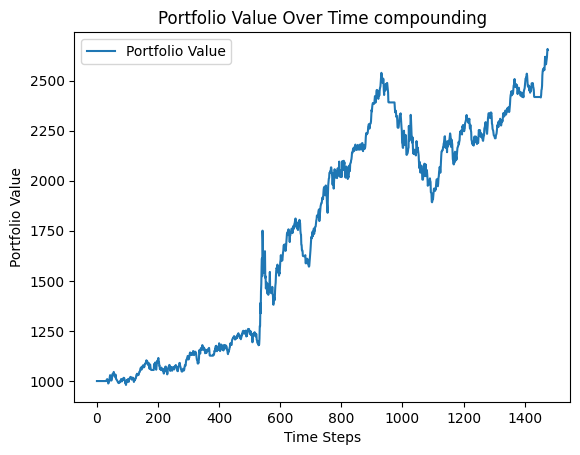

The dawdown percentage is--
24.308467470706656
--------------------------------------------
The profit percentage is :
165.1971576074443
--------------------------------------------
The number of profitable trades are :-
13
---------------------------------------------
The number of losing trades is :-
16


In [6]:
numberOfTrades = 0
numberOfWinningTrades = 0
numberOfLosingTrades = 0
averageWinningTrade = 0.0
averageLosingTrade = 0.0
maxWinningTrade = 0.0
maxLosingTrade = 0.0
averageHoldOut = 0.0
lastPrice = 0.0
signal_column = 'signals'
initialCash = 1000
cash = initialCash
position = 0
portfolio = []
count = 0
maxDrawDown = 0.0
sharpeRatio = 0.0
sortinioRatio=0.0
priceColumn = 'Close'
investmentAmount= 1000
commision = 0.1

def getCompleteInfo3Compound(df): #assumes signal represents entry/exit, PNL= (Exit Price−Entry Price) ×  Investment amount/Entry price, 0.1%comission
  global numberOfTrades, numberOfWinningTrades, numberOfLosingTrades, averageWinningTrade, averageLosingTrade, maxWinningTrade, maxLosingTrade, averageHoldOut, signal_column, cash, position, portfolio
  global lastPrice,priceColumn,investmentAmount,initialCash
  startInvestment = 1000
  investmentAmount = initialCash
  multipleBuys = False
  multipleSells = False
  currentHoldOut = 0
  entryPrice = 0
  exitPrice=0
  currentHoldOut = 0
  for index,row in df.iterrows():
    investmentAmount = cash
    signal = row[signal_column]
    currPrice = row[priceColumn]
    if position==0:
      portfolio.append(cash)
      if signal==1:
        position=1
        entryPrice = currPrice
        currentHoldOut=1
      elif signal==-1:
        position=-1
        currentHoldOut=1
        exitPrice = currPrice
    elif position==1:
      portfolio.append(cash-investmentAmount+investmentAmount/entryPrice*currPrice)
      if signal==0:
        currentHoldOut+=1
      elif signal==-1:
        currentHoldOut+=1
        averageHoldOut = (averageHoldOut*numberOfTrades + currentHoldOut)/(numberOfTrades+1)
        currentHoldOut=0
        numberOfTrades+=1
        change = investmentAmount/entryPrice*(currPrice-entryPrice)
        cash+=change
        cash-=commision/100*investmentAmount
        position=0
        if change>0:
          averageWinningTrade = (averageWinningTrade*numberOfWinningTrades+change)/(numberOfWinningTrades+1)
          numberOfWinningTrades+=1
          maxWinningTrade = max(maxWinningTrade,change)
        elif change<0:
          change*=-1
          averageLosingTrade = (averageLosingTrade*numberOfLosingTrades+change)/(numberOfLosingTrades+1)
          numberOfLosingTrades+=1
          maxLosingTrade = max(maxLosingTrade, change)
      else:
        multipleBuys = True
    elif position==-1:
      portfolio.append(cash-investmentAmount+investmentAmount/currPrice*exitPrice)
      if signal==0:
        currentHoldOut+=1
      elif signal==1:
        currentHoldOut+=1
        averageHoldOut = (averageHoldOut*numberOfTrades + currentHoldOut)/(numberOfTrades+1)
        currentHoldOut=0
        numberOfTrades+=1
        change = investmentAmount/currPrice*(exitPrice-currPrice)
        cash+=change
        cash-=commision/100*investmentAmount
        position=0
        if change>0:
          averageWinningTrade = (averageWinningTrade*numberOfWinningTrades+change)/(numberOfWinningTrades+1)
          numberOfWinningTrades+=1
          maxWinningTrade = max(maxWinningTrade,change)
        elif change<0:
          change*=-1
          averageLosingTrade = (averageLosingTrade*numberOfLosingTrades+change)/(numberOfLosingTrades+1)
          numberOfLosingTrades+=1
          maxLosingTrade = max(maxLosingTrade, change)
      else:
        multipleSells = True
  df['portfolio']= portfolio
  if multipleBuys:
    print("Your signals attempt to hold more than 1 position")
  if multipleSells:
    print("Your signals attempt to sell more than 1 position")
  investmentAmount = startInvestment
  print("The number of Trades being executed")
  print(numberOfTrades)
  return portfolio

portfolio = getCompleteInfo3Compound(data)
time_steps = range(len(portfolio))

plt.plot(time_steps, portfolio, label='Portfolio Value')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time compounding')
plt.legend()
plt.show()

def get_max_drawdown_fast(array):
    drawdowns = []
    #capital_at_drawdown = []
    max_so_far = array[0]
    for i in range(len(array)):
        if array[i] > max_so_far:
            drawdown = 0
            drawdowns.append(drawdown)
            max_so_far = array[i]
        else:
            drawdown = max_so_far - array[i]
            drawdowns.append(drawdown)

    max_dd = max(drawdowns)
    idx = drawdowns.index(max_dd)
    return max_dd, max_so_far

max_drawdown, capital_temp = get_max_drawdown_fast(portfolio)
print("The dawdown percentage is--")
print((max_drawdown/capital_temp)*100)
print("--------------------------------------------")
print("The profit percentage is :")
print((portfolio[-1] - portfolio[0]) / portfolio[0] * 100)
print("--------------------------------------------")
print('The number of profitable trades are :-')
print(numberOfWinningTrades)
print("---------------------------------------------")
print('The number of losing trades is :-')
print(numberOfLosingTrades)